# Content

This notebook contains the simulation of the 2D ion crystal consisting of 4 ions and calculation of its normal modes.

The normal modes are calculated with *sion.normal_modes()* function. The normal modes are verified through the calculation of the fast Fourier transform (FFT) of the simulated ion trajectories. The method comes as follows:
1. Calculate equilibrium ion positions from the simulation with cooling.
2. Calculate normal modes of the resulting crystal by *sion.normal_modes()*.
3. Perform simulation of ion crystal without cooling, with starting ion positions being pushed by random small kick from the equilibrium.  
4. Calculate FFT on the simulated trajectories for each ion.  
5. Compare calculated normal modes with FFT.

In [68]:
from __future__ import division
import pylion as pl
from pathlib import Path
import matplotlib.pyplot as plt, numpy as np, scipy.constants as ct
from electrode import (System, PolygonPixelElectrode, euler_matrix,
                       PointPixelElectrode, PotentialObjective,
                       PatternRangeConstraint, shaped)
import sion as sn

## Trap definition

Trap with high enough anisotropy parameter $\alpha = \omega_x^2/\omega_y^2$ for the 2D crystal of 4 ions. 

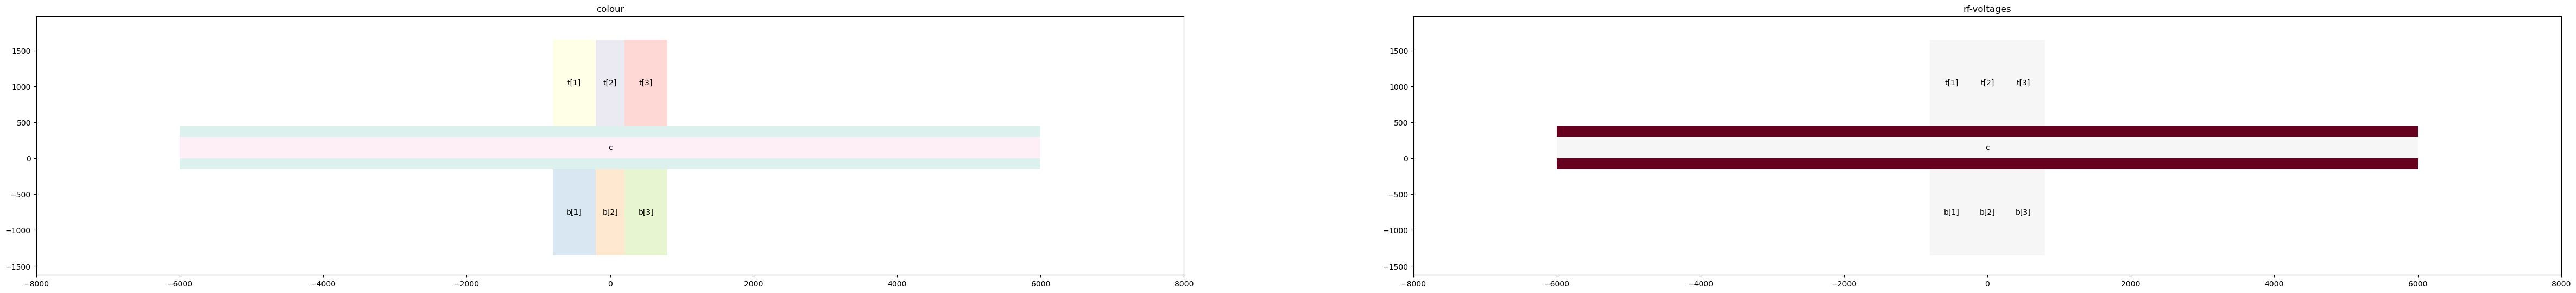

In [137]:
# Global definition of trap parameters.
L = 1e-6 # length scale
Vrf = 350 # RF peak voltage in V
mass = 40*ct.atomic_mass # ion mass
Z = 1*ct.elementary_charge # ion charge
Omega = 2*np.pi*30e6 # RF frequency in rad/s
Urf = Vrf * np.sqrt(Z / mass) / (2 * L * Omega)
scale = Z / ((L * Omega) ** 2 * mass)

# parameters of trap
DCtop = [[1200, 600],[1200, 400],[1200, 600] ]  # Array of lengths and widths of Top electrodes
DCbottom = [[1200, 600],[1200, 400],[1200, 600] ]  # Array of lengths and widths of Bottom electrodes
cwidth = 300  # Width of central dc electrode
clength = 12000 # length of central dc electrode
boardwidth = 0  # width of gaps between electrodes
rftop = 150  # width of top rf electrode, not including width of central electrode
rflength = 12000  # length of rf electrodes
rfbottom = 150  # width of bottom rf electrode
sist, RF_electrodes, DC_electrodes = sn.five_wire_trap_design(Urf, DCtop ,DCbottom, cwidth, clength, boardwidth, rftop, rflength, rfbottom, need_coordinates = True, need_plot = True)

## Potential analysis

Here we calculate the potential minimum and normal modes of the Ca ion in this trap. The anisotropy parameter must ensure the 2D form of the resulting crystal in x-y plane.

In [138]:
x0 = L*np.array(sist.minimum((0., 1, 1), axis=(0, 1, 2), coord=np.identity(3), method="Newton-CG"))
u_set = np.array([0, 15, -15, 15, 15, -15, 15, 2.56285]) 
dc_set = [15, -15, 15, 15, -15, 15, 2.56285]

# routine to find secular frequencies in minimum point
with sist.with_voltages(dcs=u_set, rfs=None):
    # Check if the minimum was shifted
    x = sist.minimum((x0/L-np.ones(3)), axis=(0, 1, 2), coord=np.identity(3), method="Newton-CG")
    print('Potential minimum: (%.3g, %.3g, %.3g) um' % (x[0], x[1], x[2]))
    print('Distance from RF minimum:', x-x0/L, 'um')
    # Get trap frequencies
    try:
        curv_z, mod_dir = sist.modes(x, sorted=False)
        omega_sec = np.sqrt(Z * curv_z / mass) / (L * 2 * np.pi) * 1e-6
        print("Secular frequencies: (%.4g, %.4g, %.4g) MHz" % (omega_sec[0], omega_sec[1], omega_sec[2]))
        print("In directions \n", mod_dir)
    except:
        print("secular frequencies not found")
print("Anisotropy parameter: %.3g" % (omega_sec[0]**2/omega_sec[1]**2))
omega_sec *=1e6
x0 = x*1e-6



Potential minimum: (1.9e-05, 150, 212) um
Distance from RF minimum: [ 1.90e-05 -2.33e-02  9.05e-06] um
Secular frequencies: (1.13, 1.508, 2.564) MHz
In directions 
 [[ 1.00e+00  4.40e-11 -2.07e-10]
 [ 4.40e-11 -1.00e+00 -2.89e-04]
 [-2.07e-10  2.89e-04 -1.00e+00]]
Anisotropy parameter: 0.562


## Anharmonicity analysis

Since we will consider exact ion oscillations with normal modes, calculated in harmonic approximation, it is necessary to understand the degree of anharmonicity in this trap. For the 5-wire geometry we can minimize anharmonicity in y axis, but not in z-axis, which will be demonstrated later by FFT calcualtion.

In [140]:
with sist.with_voltages(dcs = u_set, rfs = None):
    scales_y = sn.anharmonics(sist, [x], 1, L)
    scales_z = sn.anharmonics(sist, [x], 2, L)
    
print('Anharmonic scale length in y-direction\nl2 =', scales_y[0][0], '\nl3 =', scales_y[0][1], '\nl4 =', scales_y[0][2])
print('Anharmonic scale length in z-direction\nl2 =', scales_z[0][0], '\nl3 =', scales_z[0][1], '\nl4 =', scales_z[0][2])


Anharmonic scale length in y-direction
l2 = 3.3818596690823717e-06 
l3 = 0.0731824609263741 
l4 = -0.0004894307368261227
Anharmonic scale length in z-direction
l2 = 2.3739168173467416e-06 
l3 = -2.8234867536498996e-05 
l4 = 3.278307216585316e-05


## Equilibrium ion positions

The simulation of 4 ions is performed in the presence of cooling, to obtain their equilibrium positions.

In [97]:
ion_number = 4
x0 = x*1e-6

"""Simulation"""

#insert your path to this file here
name = Path("2D_crystal_modes.ipynb").stem

s = pl.Simulation(name)

#ions' declaration
ions = {'mass': 40, 'charge': 1}

#placing ion in random cloud near minimum
positions = sn.ioncloud_min(x0, ion_number, 5e-6)
s.append(pl.placeions(ions, positions))

#declaration of a five wire trap
s.append(sn.polygon_trap([Omega, Omega], [Vrf, Vrf], dc_set, RF_electrodes, DC_electrodes))

#cooling simulation
s.append(pl.langevinbath(0, 1e-7))

#files with simulation information
s.append(pl.dump('2Dpositions3_eq.txt', variables=['x', 'y', 'z'], steps=10))
s.append(pl.evolve(2e5))
s.execute()

Reducing timestep to 2.652582384864922e-10 sec
LAMMPS (3 Mar 2020)
OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (../comm.cpp:94)
  using 1 OpenMP thread(s) per MPI task
Created orthogonal box = (-0.01 -0.01 -0.01) to (0.01 0.01 0.01)
  1 by 1 by 1 MPI processor grid
Created 1 atoms.
Created 1 atoms.
Created 1 atoms.
Created 1 atoms.
Setting atom values ...
  4 settings made for charge
4 atoms in group 1
4 atoms in group nonRigidBody
Neighbor list info ...
  update every 1 steps, delay 10 steps, check yes
  max neighbors/atom: 2000, page size: 100000
  master list distance cutoff = 11
  ghost atom cutoff = 11
  1 neighbor lists, perpetual/occasional/extra = 1 0 0
  (1) pair coul/cut, perpetual
      attributes: half, newton on
      pair build: half/nsq/newton
      stencil: none
      bin: none
Setting up Verlet run ...
  Unit style    : si
  Current step  : 0
  Time step     : 2.65258e-10
Per MPI rank memory allocation (min/avg/max) = 4.78 | 4.78 | 4.78 Mbytes
Step 

C:\Users\User_A\anaconda3\lib\site-packages\pylion-0.5.2-py3.9.egg\pylion\utils.py:95: UserWarning: Caller source not saved. Are you running the simulation from the REPL?
  warnings.warn(


Since some degree of micromotion can not be eliminated, for precise calculation, equilibrium positions are calculated as mean ion positions at the end of simulation (after cooling).

Final positions of ions in um:
 [[-4.78e+00  1.50e+02  2.12e+02]
 [-2.23e-11  1.48e+02  2.12e+02]
 [ 2.21e-11  1.52e+02  2.12e+02]
 [ 4.78e+00  1.50e+02  2.12e+02]]


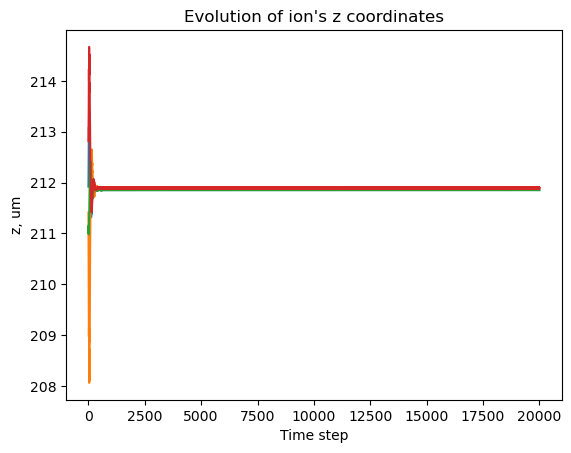

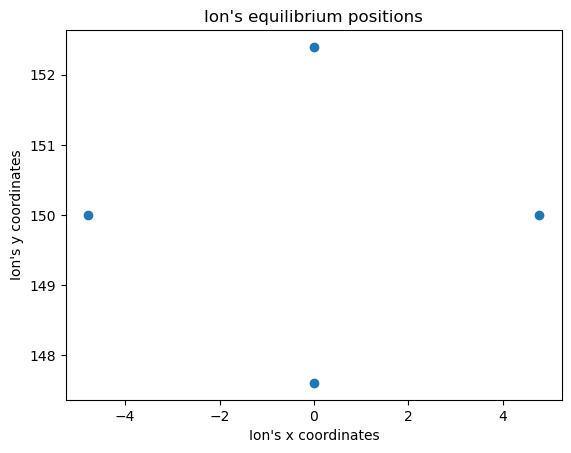

In [100]:
ion_number = 4
_, data = pl.readdump('2Dpositions3_eq.txt')
data *= 1e6

final_x = data[-1, :, 0]
final_y = data[-1, :, 1]
final_z = data[-1, :, 2]

ion_positions = np.zeros([ion_number, 3])
sort = np.argsort(final_x)

k=0
for i in sort:
    ion_positions[k] = np.array([final_x[i], final_y[i], final_z[i]])
    k+=1

np.set_printoptions(2)
print('Final positions of ions in um:\n', ion_positions)


plt.figure()
for n in range(ion_number):
    plt.plot(data[:, n, 2])
plt.title('Evolution of ion\'s z coordinates')
plt.xlabel('Time step')
plt.ylabel('z, um')
plt.show()

# Plot of the final ion crystal configuration
plt.figure()
plt.scatter(data[-1, :, 0], data[-1, :, 1])
plt.title('Ion\'s equilibrium positions')
plt.xlabel('Ion\'s x coordinates')
plt.ylabel('Ion\'s y coordinates')
#plt.ylim([60, 80])
plt.show()


## Ion crystal normal modes

For this 2D crystal we calculate normal mode vectors and their frequencies. 

[[ 4.78e-06  1.50e-04  2.12e-04]
 [-4.60e-18  1.47e-04  2.12e-04]
 [-4.78e-06  1.50e-04  2.12e-04]
 [ 4.50e-18  1.53e-04  2.12e-04]]
Mode index: 1, Frequency: 500161 Hz
Vector: [0.0, 0.52351, -0.0, -0.52351, 0.47532, -0.0, -0.47532, 0.0, 0.0, -0.0, 0.0, -0.0]
Mode index: 2, Frequency: 1130282 Hz
Vector: [0.5, 0.5, 0.5, 0.5, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, -0.0, 0.0]
Mode index: 3, Frequency: 1283008 Hz
Vector: [0.0, -0.0, 0.0, -0.0, 0.49999, -0.49999, 0.49999, -0.49999, 0.0, -0.00455, -0.0, 0.00455]
Mode index: 4, Frequency: 1478186 Hz
Vector: [0.59403, -0.0, -0.59403, 0.0, 0.0, 0.38354, -0.0, -0.38354, 0.00373, -0.00373, 0.00373, -0.00373]
Mode index: 5, Frequency: 1508215 Hz
Vector: [0.0, -0.0, -0.0, 0.0, -0.5, -0.5, -0.5, -0.5, 0.0, 0.0, 0.0, -0.0]
Mode index: 6, Frequency: 1732933 Hz
Vector: [0.0, 0.47532, -0.0, -0.47532, -0.52351, 0.0, 0.52351, -0.0, 0.0, -0.0, 0.0, -0.0]
Mode index: 7, Frequency: 2013983 Hz
Vector: [0.49984, -0.49984, 0.49984, -0.49984, -0.0, 0.0, -0.0, 0.0, 0.0

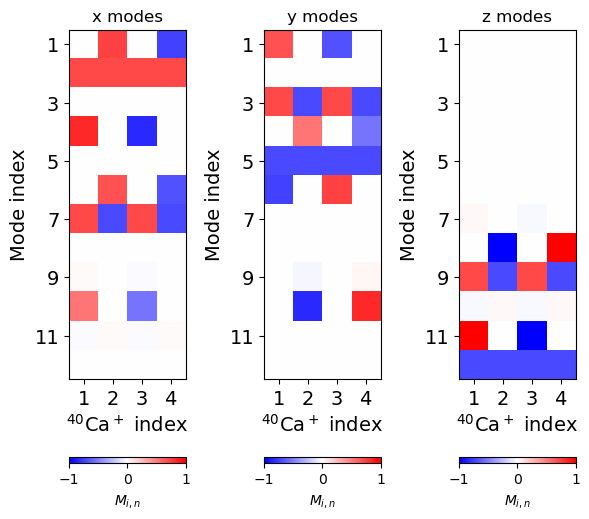

In [103]:
ion_masses = [mass for el in range(ion_number)]
omegas = [omega_sec for el in range(ion_number)]

equilibrium_positions = []
for i in range(ion_number):
    equilibrium_positions.append(L*np.array([np.mean(data[19000:, i, 0]), np.mean(data[19000:, i, 1]), np.mean(data[19000:, i, 2])]))
equilibrium_positions = np.array(equilibrium_positions)

#obtaining normal modes, for general case
freqs, modes = sn.normal_modes(equilibrium_positions, omegas, ion_masses)
for i, mode in enumerate(modes):
    print(f'Mode index: {i+1}, Frequency: {int(np.round(freqs[i], 0))} Hz')
    print(f'Vector: {list(np.round(mode, 5))}')

fig, ax = plt.subplots(1, 3, figsize = [6, 10])
ax[0].set_title('x modes')
ax[1].set_title('y modes')
ax[2].set_title('z modes')
for i in range(3):
    im = ax[i].imshow(modes[:,i*ion_number:(i+1)*ion_number] / np.max(np.abs(modes[:])), cmap='bwr', vmin = -1, vmax =1)
    ax[i].set_xlabel('$^{40}$Ca$^+$ index', fontsize = 14)
    ax[i].set_ylabel('Mode index', fontsize = 14)
    ax[i].set_xticks([0, 1, 2, 3],[1, 2, 3, 4],fontsize = 14)
    ax[i].set_yticks([0, 2, 4, 6, 8, 10],[1, 3, 5, 7, 9, 11], fontsize = 14)
    cb = fig.colorbar(im, ax=ax[i], orientation='horizontal', shrink = 1, pad = 0.08)
    cb.set_label('$M_{i,n}$')
    
plt.tight_layout()
plt.show()


# Normal frequencies from Fourier analysis

## Simulation without cooling

This block performs simulation of ions near their equilibrium positions, oscillating from random initial displacement.

In [111]:
start_positions = []
for pos in equilibrium_positions:
    start_positions.append((pos + L*0.001*(np.random.rand(3)-np.ones(3))))
    
    
"""Simulation"""

#insert your path to this file here
name = Path("2D_crystal_modes.ipynb").stem

s = pl.Simulation(name)

#ions' declaration
ions = {'mass': 40, 'charge': 1}

#placing ion in random cloud near minimum
s.append(pl.placeions(ions, start_positions))
#s.append(pl.langevinbath(1e-7, 1e-7))

#declaration of a five wire trap
s.append(sn.polygon_trap([Omega, Omega], [Vrf, Vrf], [15, -15, 15, 15, -15, 15, 2.56], RF_electrodes, DC_electrodes))

#files with simulation information
s.append(pl.dump('2Dpositions_3.txt', variables=['x', 'y', 'z'], steps=1))
s.append(pl.evolve(1e6))
s.execute()

Reducing timestep to 2.652582384864922e-10 sec
LAMMPS (3 Mar 2020)
OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (../comm.cpp:94)
  using 1 OpenMP thread(s) per MPI task
Created orthogonal box = (-0.01 -0.01 -0.01) to (0.01 0.01 0.01)
  1 by 1 by 1 MPI processor grid
Created 1 atoms.
Created 1 atoms.
Created 1 atoms.
Created 1 atoms.
Setting atom values ...
  4 settings made for charge
4 atoms in group 1
4 atoms in group nonRigidBody
Neighbor list info ...
  update every 1 steps, delay 10 steps, check yes
  max neighbors/atom: 2000, page size: 100000
  master list distance cutoff = 11
  ghost atom cutoff = 11
  1 neighbor lists, perpetual/occasional/extra = 1 0 0
  (1) pair coul/cut, perpetual
      attributes: half, newton on
      pair build: half/nsq/newton
      stencil: none
      bin: none
Setting up Verlet run ...
  Unit style    : si
  Current step  : 0
  Time step     : 2.65258e-10
Per MPI rank memory allocation (min/avg/max) = 4.78 | 4.78 | 4.78 Mbytes
Step 

## Ion trajectories

These plots show x-trajectories of each ion during the simulation. We observe harmonic-like oscillations, corresponding to ions secular and micro- motion. 

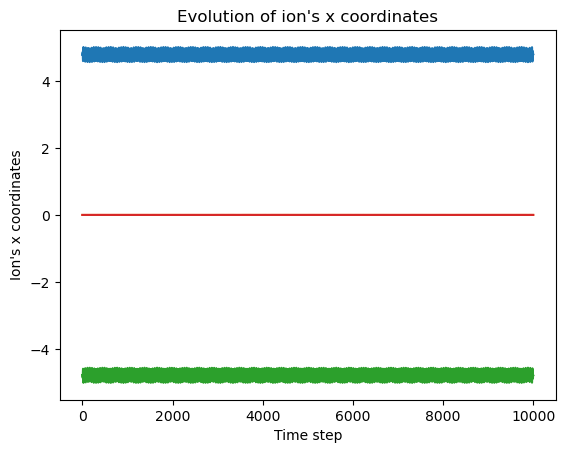

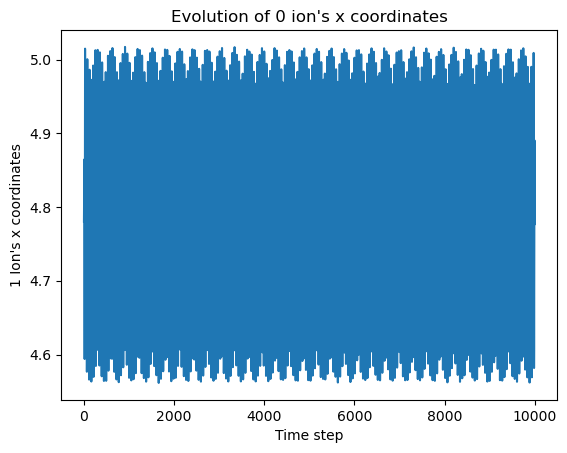

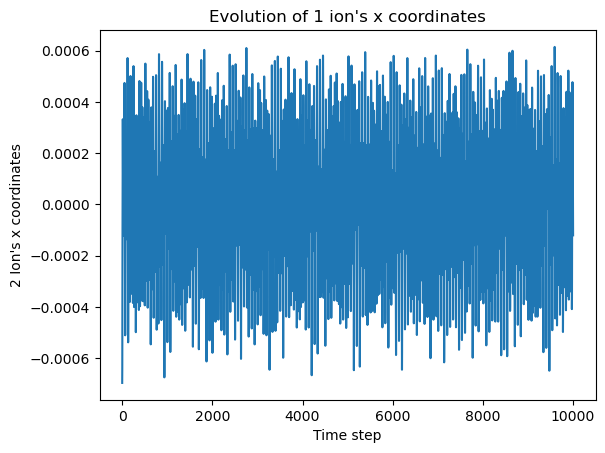

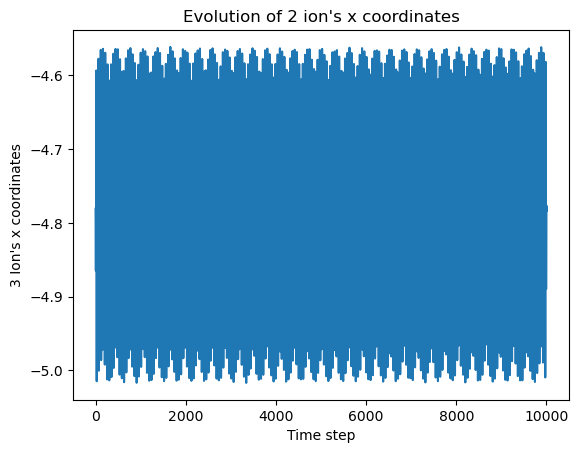

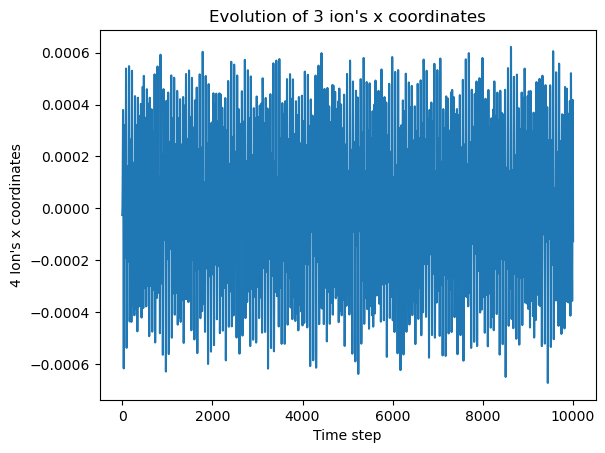

In [112]:
_, data = pl.readdump('2Dpositions_3.txt')
data *= 1e6

plt.figure()
for n in range(ion_number):
    plt.plot(data[::100, n, 0])
plt.title('Evolution of ion\'s x coordinates')
plt.xlabel('Time step')
plt.ylabel('Ion\'s x coordinates')
plt.show()

for n in range(ion_number):
    plt.figure()
    plt.plot(data[::100, n, 0])
    plt.title('Evolution of ' + str(n) +' ion\'s x coordinates')
    plt.xlabel('Time step')
    plt.ylabel(str(n+1) +' Ion\'s x coordinates')
    plt.show()

## Calculation of FFT frequencies

The following block performs FFT on each ion's trajectories in each of 3 principle axes.

In [115]:
x = data[:, :, 0]
y = data[:, :, 1]
z = data[:, :, 2]

timestep = 1/(20*Omega)
freqsfft = np.fft.fftfreq(data.shape[0], timestep)

normal_spectrum_x = []
normal_spectrum_y = []
normal_spectrum_z = []

for i in range(ion_number):
    ion_spectrum_x = np.fft.fft(x[:, i])
    normal_spectrum_x.append(np.abs(ion_spectrum_x))
    ion_spectrum_y = np.fft.fft(y[:, i])
    normal_spectrum_y.append(np.abs(ion_spectrum_y))
    ion_spectrum_z = np.fft.fft(z[:, i])
    normal_spectrum_z.append(np.abs(ion_spectrum_z))

# Verification 

This block presents the frequencies of each mode, calculated with *sion.normal_modes()*, for each of 4 ions, if the normal vector, corresponding to ion *i* and mode *n* is more then 0.1. We observe that each normal mode, affecting the ion, matches with some oscillation in trajectory. Additionally, there are some oscillation, that do not correspond to any normal modes. These can be explained from some non-harmonic motion, occuring in the trap.

## X modes

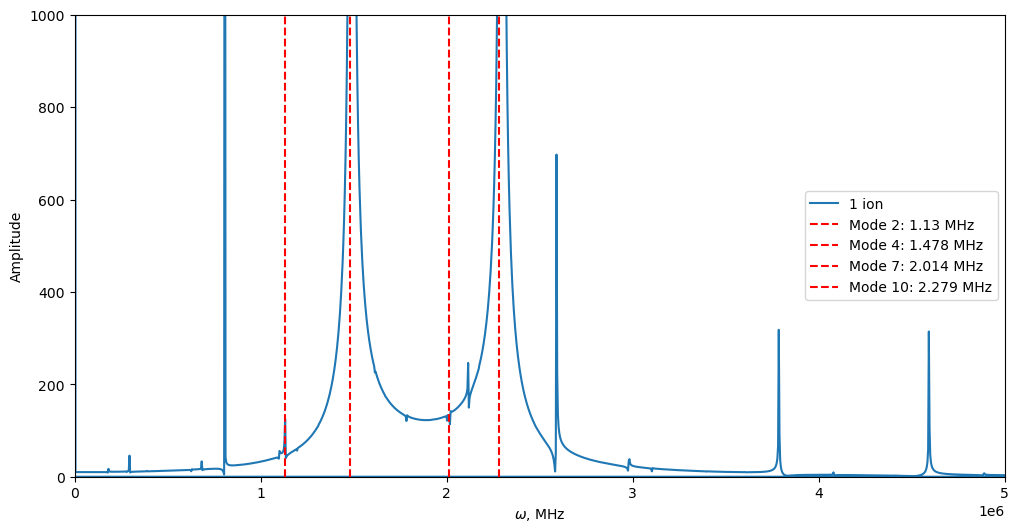

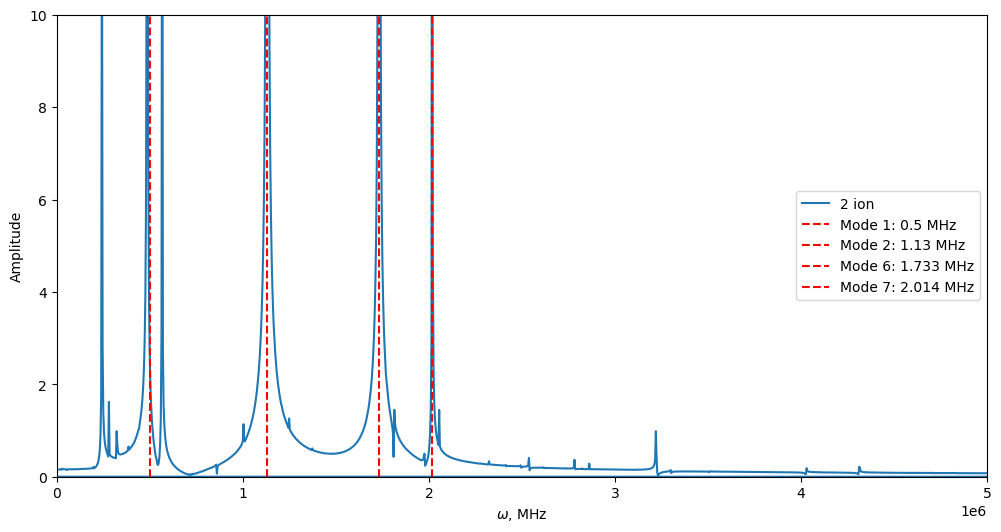

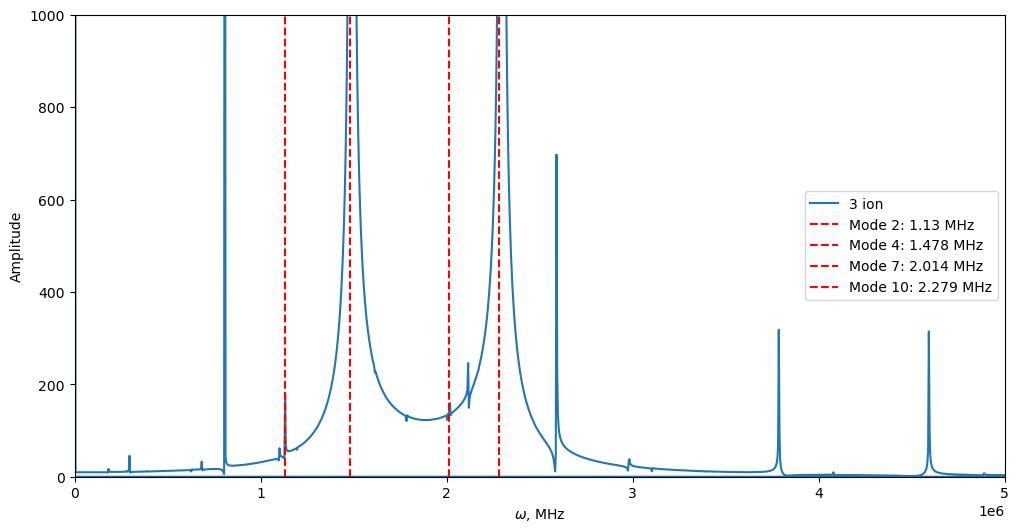

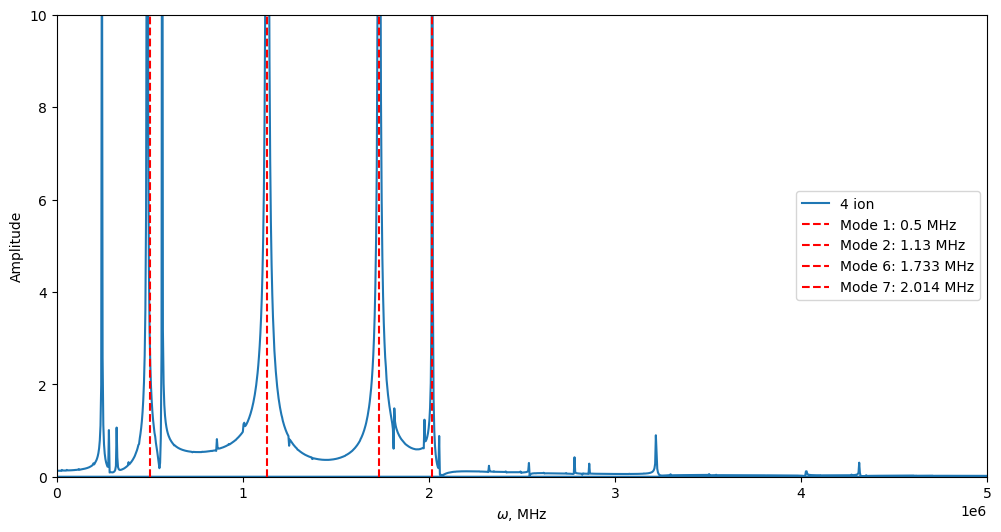

In [124]:
for n, ion_spectrum in enumerate(normal_spectrum_x):
    plt.figure(figsize = (12,6))
    plt.plot(freqsfft, ion_spectrum, label = f'{n+1} ion')
    for i, mode in enumerate(modes):
        if np.abs(mode[n]) > 0.1:
            plt.axvline(freqs[i], c = 'r', ls = '--', label = f'Mode {i+1}: {np.round(freqs[i]/1e6, 3)} MHz')
    plt.legend(loc = 'right')
    plt.xlabel('$\omega$, MHz')
    plt.xlim(0, 5e6)
    if n == 0 or n == 2:
        plt.ylim(0, 1000)
    else:
        plt.ylim(0, 10)
    plt.ylabel('Amplitude')
    plt.show()

## Y modes

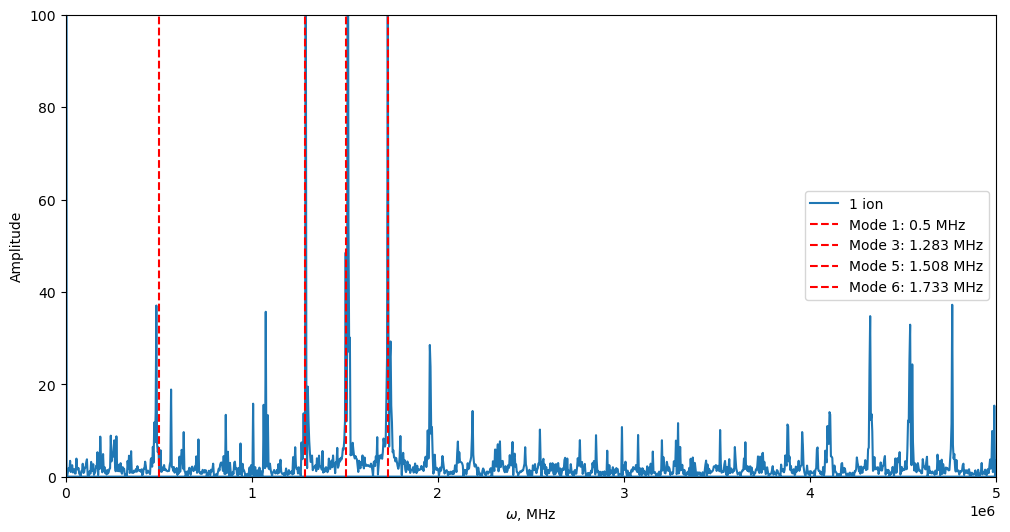

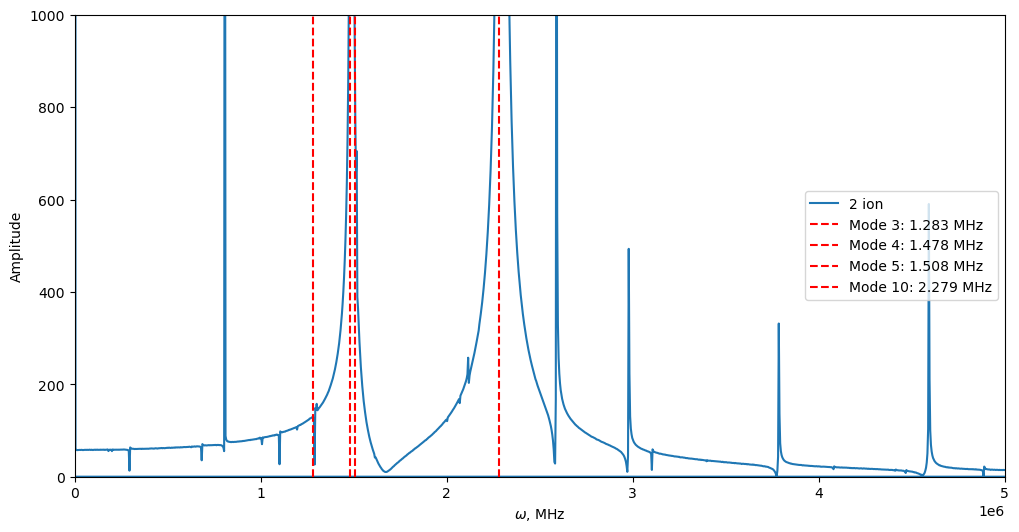

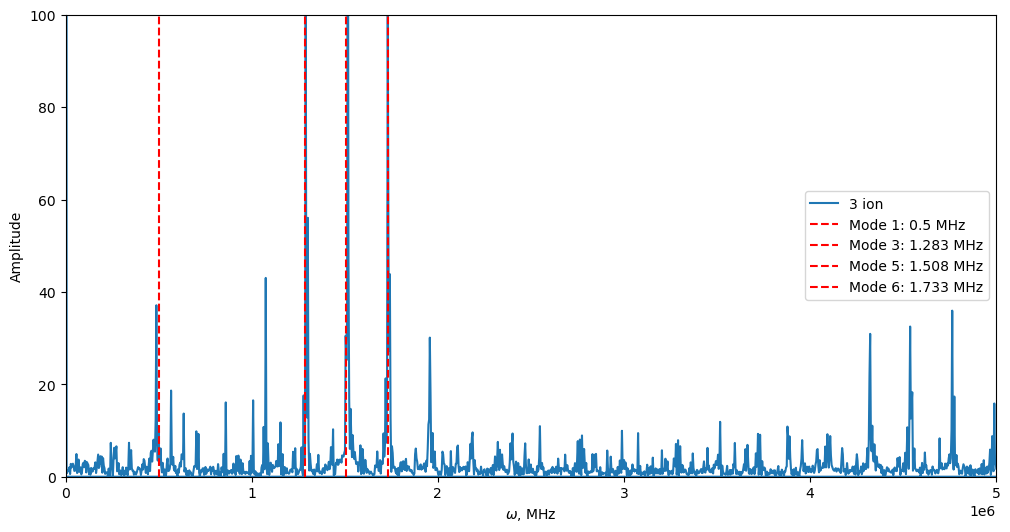

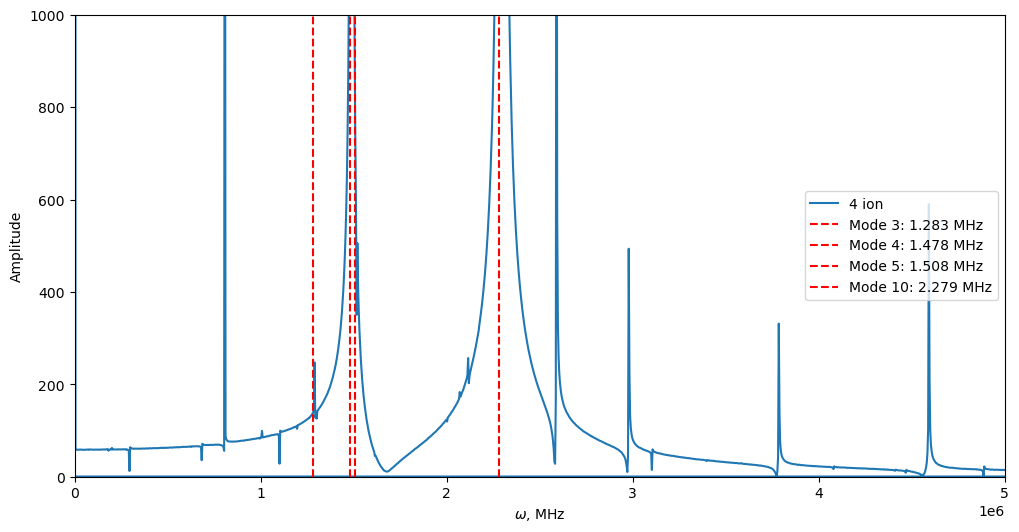

In [126]:
for n, ion_spectrum in enumerate(normal_spectrum_y):
    plt.figure(figsize = (12,6))
    plt.plot(freqsfft, ion_spectrum, label = f'{n+1} ion')
    for i, mode in enumerate(modes):
        if np.abs(mode[n+ion_number]) > 0.1:
            plt.axvline(freqs[i], c = 'r', ls = '--', label = f'Mode {i+1}: {np.round(freqs[i]/1e6, 3)} MHz')
    plt.legend(loc = 'right')
    plt.xlabel('$\omega$, MHz')
    plt.xlim(0, 5e6)
    if n == 0 or n == 2:
        plt.ylim(0, 100)
    else:
        plt.ylim(0, 1000)
    plt.ylabel('Amplitude')
    plt.show()

## Z modes

Note, that the frequencies of normal modes do not match with oscillations of z-trajectories. This is due to the larger anharmonicity in z direction, affecting ions. 

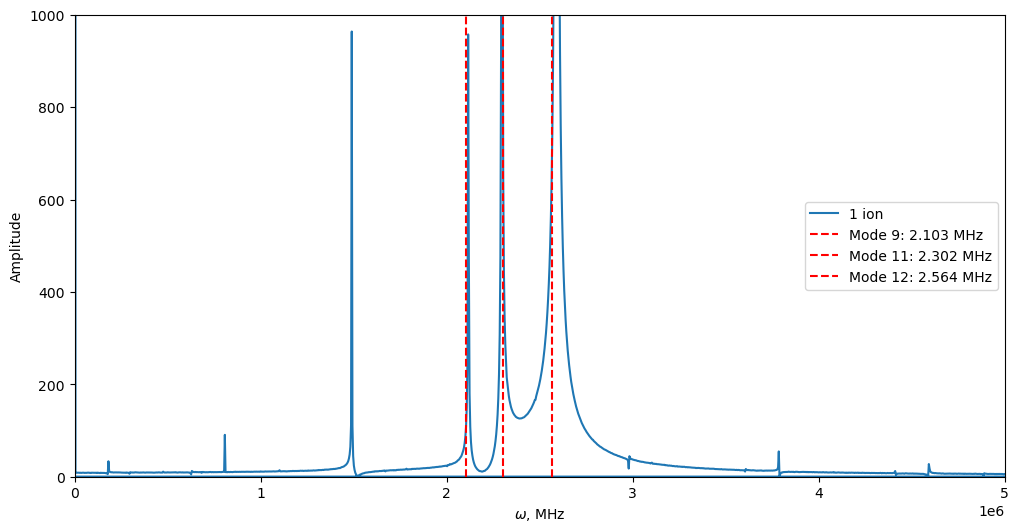

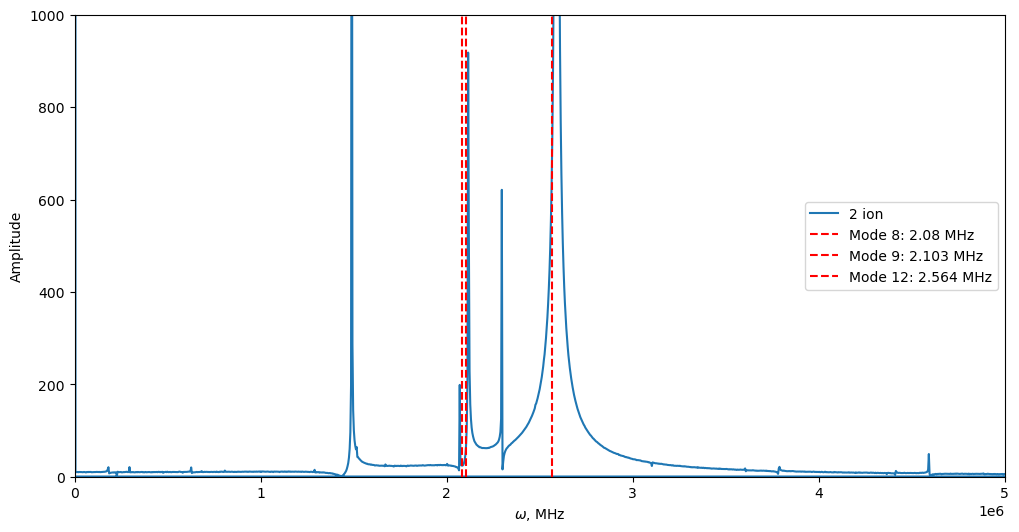

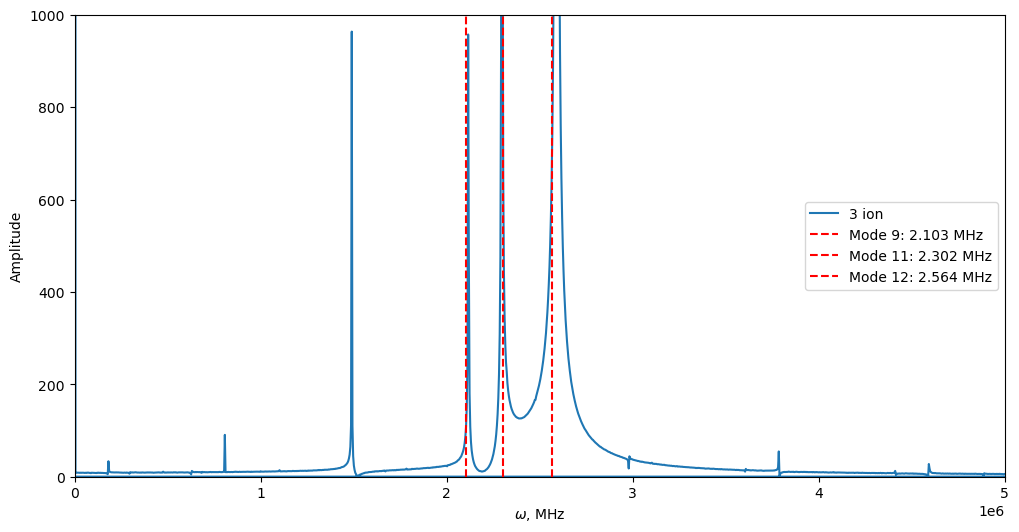

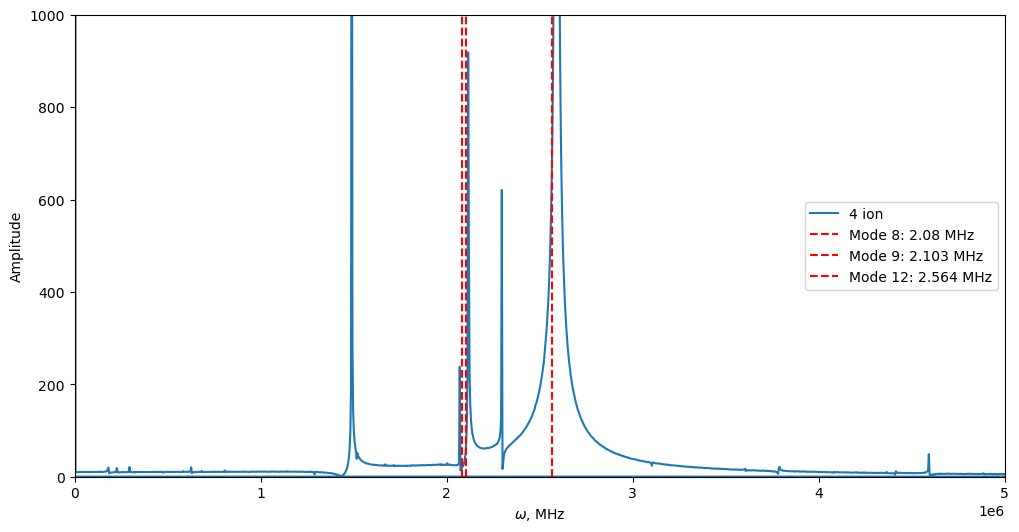

In [142]:
for n, ion_spectrum in enumerate(normal_spectrum_z):
    plt.figure(figsize = (12,6))
    plt.plot(freqsfft, ion_spectrum, label = f'{n+1} ion')
    for i, mode in enumerate(modes):
        if np.abs(mode[n+2*ion_number]) > 0.1:
            plt.axvline(freqs[i], c = 'r', ls = '--', label = f'Mode {i+1}: {np.round(freqs[i]/1e6, 3)} MHz')
    plt.legend(loc = 'right')
    plt.xlabel('$\omega$, MHz')
    plt.xlim(0, 5e6)
    plt.ylim(0, 1000)
    plt.ylabel('Amplitude')
    plt.show()